In [1]:
import os
import numpy as np
from config import config
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Ignore all infos and error messages

In [2]:
data = []
labels = []

imagePaths = list(paths.list_images(config.DATA_PATH))

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(config.IMG_SIZE, config.IMG_SIZE))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)
print('Class Labels: ',np.unique(labels))
    
# Convert to Numpy array
data = np.array(data, dtype=np.float32)
labels = np.array(labels)

# one-hot the labels
lE = LabelEncoder()
labels = lE.fit_transform(labels)
labels = to_categorical(labels, num_classes=3)

print(data.shape)
print(labels.shape)
print('One hot encoded{}'.format(labels[0:3]))

Class Labels:  ['incorrect_mask' 'with_mask' 'without_mask']
(2719, 112, 112, 3)
(2719, 3)
One hot encoded[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [3]:
# Split the data into 80% train and 20% test
train_data, test_data, train_labels, test_labels = train_test_split(data, labels,test_size=0.2, 
                                                                    random_state=42)

#construct the training image generator for data augmentation
datagen = ImageDataGenerator(rotation_range=20,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.15,
                            horizontal_flip=True,
                            fill_mode='nearest')
datagen.fit(train_data)

print(train_data.shape, test_data.shape)

(2175, 112, 112, 3) (544, 112, 112, 3)


# Transfer Learning

In [4]:
# Load the Resnet Network
baseModel = ResNet50(weights = 'imagenet', # load the pre-trained weights on imagenet
                     include_top = False, # make sure the top layer is turned off
                     input_tensor = Input(shape=(config.IMG_SIZE, config.IMG_SIZE, config.CHANNEL)))

# Construct the headModel that will be placed on top of the baseModel
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(320, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
predictions = Dense(3, activation='softmax')(headModel)

# Place the headModel on top of the baseModel (this becomes the actual model we will train)
model = Model(inputs = baseModel.input, outputs = predictions)

# Loop over all  layers in the baseModel so that they will not be updated in the first training process
for layer in baseModel.layers:
    layer.trainable = False

# Compile the Model

In [5]:
print('Compiling the Model'+'...'*5)
# Adam optimizer
opt = tf.keras.optimizers.Adam(lr = config.LEARNING_RATE, decay = config.LEARNING_RATE / config.EPOCH)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

Compiling the Model...............


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 118, 118, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 56, 56, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 56, 56, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# Train the Model

In [7]:
print('Training the Model'+'...'*5)

History = model.fit(datagen.flow(train_data, train_labels, batch_size = config.BATCH_SIZE2),
                    steps_per_epoch=len(train_data) // config.BATCH_SIZE2, 
                    validation_steps=len(test_data) // config.BATCH_SIZE2,
                    validation_data=(test_data, test_labels),
                    epochs = config.EPOCH)

Training the Model...............
Epoch 1/20
1087/1087 [==============================] - 137s 126ms/step - loss: 0.4978 - accuracy: 0.8302 - val_loss: 0.1389 - val_accuracy: 0.9522
Epoch 2/20
1087/1087 [==============================] - 148s 136ms/step - loss: 0.2101 - accuracy: 0.9268 - val_loss: 0.1306 - val_accuracy: 0.9522
Epoch 3/20
1087/1087 [==============================] - 152s 140ms/step - loss: 0.1709 - accuracy: 0.9411 - val_loss: 0.0992 - val_accuracy: 0.9651
Epoch 4/20
1087/1087 [==============================] - 153s 141ms/step - loss: 0.1453 - accuracy: 0.9475 - val_loss: 0.0878 - val_accuracy: 0.9688
Epoch 5/20
1087/1087 [==============================] - 154s 142ms/step - loss: 0.1084 - accuracy: 0.9586 - val_loss: 0.1382 - val_accuracy: 0.9522
Epoch 6/20
1087/1087 [==============================] - 156s 143ms/step - loss: 0.1261 - accuracy: 0.9577 - val_loss: 0.1013 - val_accuracy: 0.9688
Epoch 7/20
1087/1087 [==============================] - 154s 142ms/step - loss

# Evaluate the Model

### Making Predictions on the testing set

In [8]:
pred_idx = model.predict(test_data, config.BATCH_SIZE2)

# for each image on the testing set we need to find the index of the label with the corresponding 
# largest predicted probability
pred_idx = np.argmax(pred_idx, axis=1)
print(classification_report(test_labels.argmax(axis=1), pred_idx, target_names=lE.classes_))

                precision    recall  f1-score   support

incorrect_mask       0.98      0.99      0.98       152
     with_mask       0.96      0.97      0.97       195
  without_mask       0.98      0.97      0.97       197

      accuracy                           0.97       544
     macro avg       0.97      0.98      0.97       544
  weighted avg       0.97      0.97      0.97       544



In [9]:
print(model.evaluate(test_data, test_labels))

17/17 [==============================] - 17s 1s/step - loss: 0.0897 - accuracy: 0.9743
[0.089748814702034, 0.9742646813392639]


# Plot of Training Loss/Accuracy

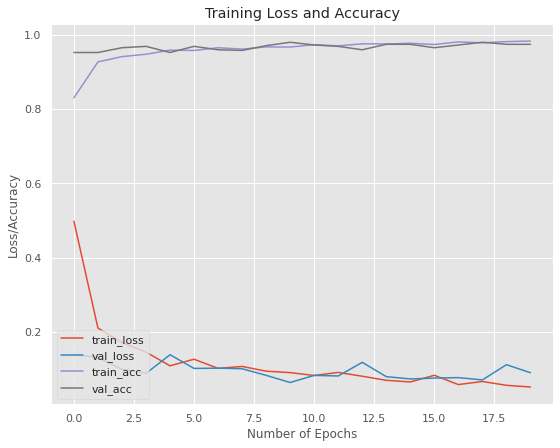

In [10]:
N = config.EPOCH
plt.style.use('ggplot')
plt.figure(figsize=(9,7))
plt.plot(np.arange(0, N), History.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), History.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot for three classes")

### The model is balanced as it do not overfits nor underfit the training data.

In [11]:
# Serialize the classifier
model.save('mask_detectorV3.model', save_format='h5')